<a href="https://colab.research.google.com/github/daniruro19/Python/blob/main/Scrapy%26Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación del proyecto

In [ ]:
# instalación de Scrapy
!pip install Scrapy

In [ ]:
# creación del proyecto
!scrapy startproject project_faces scrapy

In [ ]:
# creación del spider
!cd scrapy/project_faces && scrapy genspider FindFaces https://www.pabloalma.es/sesiones-de-fotos/fotos-de-familia/

## Edición de path/to/settings.py



*   USER_AGENT
*   ROBOTSTXT_OBEY
*   DEFAULT_REQUEST_HEADERS



In [ ]:
%%writefile scrapy/project_faces/settings.py

BOT_NAME = 'project_faces'

SPIDER_MODULES = ['project_faces.spiders']
NEWSPIDER_MODULE = 'project_faces.spiders'

USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'

ROBOTSTXT_OBEY = False

DEFAULT_REQUEST_HEADERS = {
   'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
   'Accept-Language': 'es',
}

REQUEST_FINGERPRINTER_IMPLEMENTATION = '2.7'
TWISTED_REACTOR = 'twisted.internet.asyncioreactor.AsyncioSelectorReactor'

Overwriting scrapy/project_faces/settings.py


# Implementación del spider

## Ejecución del spider

In [ ]:
%%writefile scrapy/project_faces/spiders/FindFaces.py

import scrapy

class FacesSpider(scrapy.Spider):
    name = 'FindFaces'
    allowed_domains = ['www.pabloalma.es']
    start_urls = ['https://www.pabloalma.es/sesiones-de-fotos/fotos-de-familia/']

    def parse(self, response):
        pictures = response.css('span.et_pb_image_wrap > img::attr(src)')
        print('numero de entradas:', len(pictures))
        for pic in pictures:
          href = pic.get()
          yield {
            'href': href
            }

Overwriting scrapy/project_faces/spiders/FindFaces.py


In [ ]:
!cd scrapy/project_faces && scrapy crawl FindFaces -o faces.json

## Procesando las caras de las imágenes

In [ ]:
#Realizamos las importaciones necesarias para el proyecto
from io import BytesIO
import cv2
from PIL import Image
import math
import random
import json
import numpy as np
import requests
from google.colab.patches import cv2_imshow

In [ ]:
#Cargamos el archivo json en una variable y cogemos las fotos, que estarán en el apartado href.
with open('scrapy/project_faces/faces.json', 'r') as f:
  data = json.loads(f.read())

collage = []
images = []
for item in data:
    url = item['href']
    img = Image.open(BytesIO(requests.get(url).content))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2RGBA)
    images.append(img)
    data = Image.fromarray(img)

In [ ]:
#Pasamos las caras a escala de grises e identificamos las caras que tenemos en cada foto
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces_coords = []
face_count = 0
faces_list = []
for img in images:
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor = 1.2,
        minNeighbors = 8,
        minSize = (30, 30)
  )
  for (x, y, w, h) in faces:
    face_img = img[y:y+h, x:x+w]
    faces_list.append(face_img)

In [ ]:
#Definimos la función que nos va 
def create_collage(faces_list, size=(200, 200)):
  faces_per_row = math.ceil(math.sqrt(len(faces_list)))
  while len(faces_list) % faces_per_row != 0:
    faces_list.append(random.choice(faces_list))
  counter = 1
  matrix = None
  nueva_fila = True
  for img in faces_list:
    img = np.asarray(Image.fromarray(img).resize(size))
    if nueva_fila:
      fila = img
      nueva_fila = False
    else:
      fila = np.hstack([fila, img])
    if counter == faces_per_row:
      matrix = fila
      nueva_fila = True
    elif counter % faces_per_row == 0:
      matrix = np.vstack([matrix, fila])
      nueva_fila = True
    counter += 1
  return Image.fromarray(matrix)

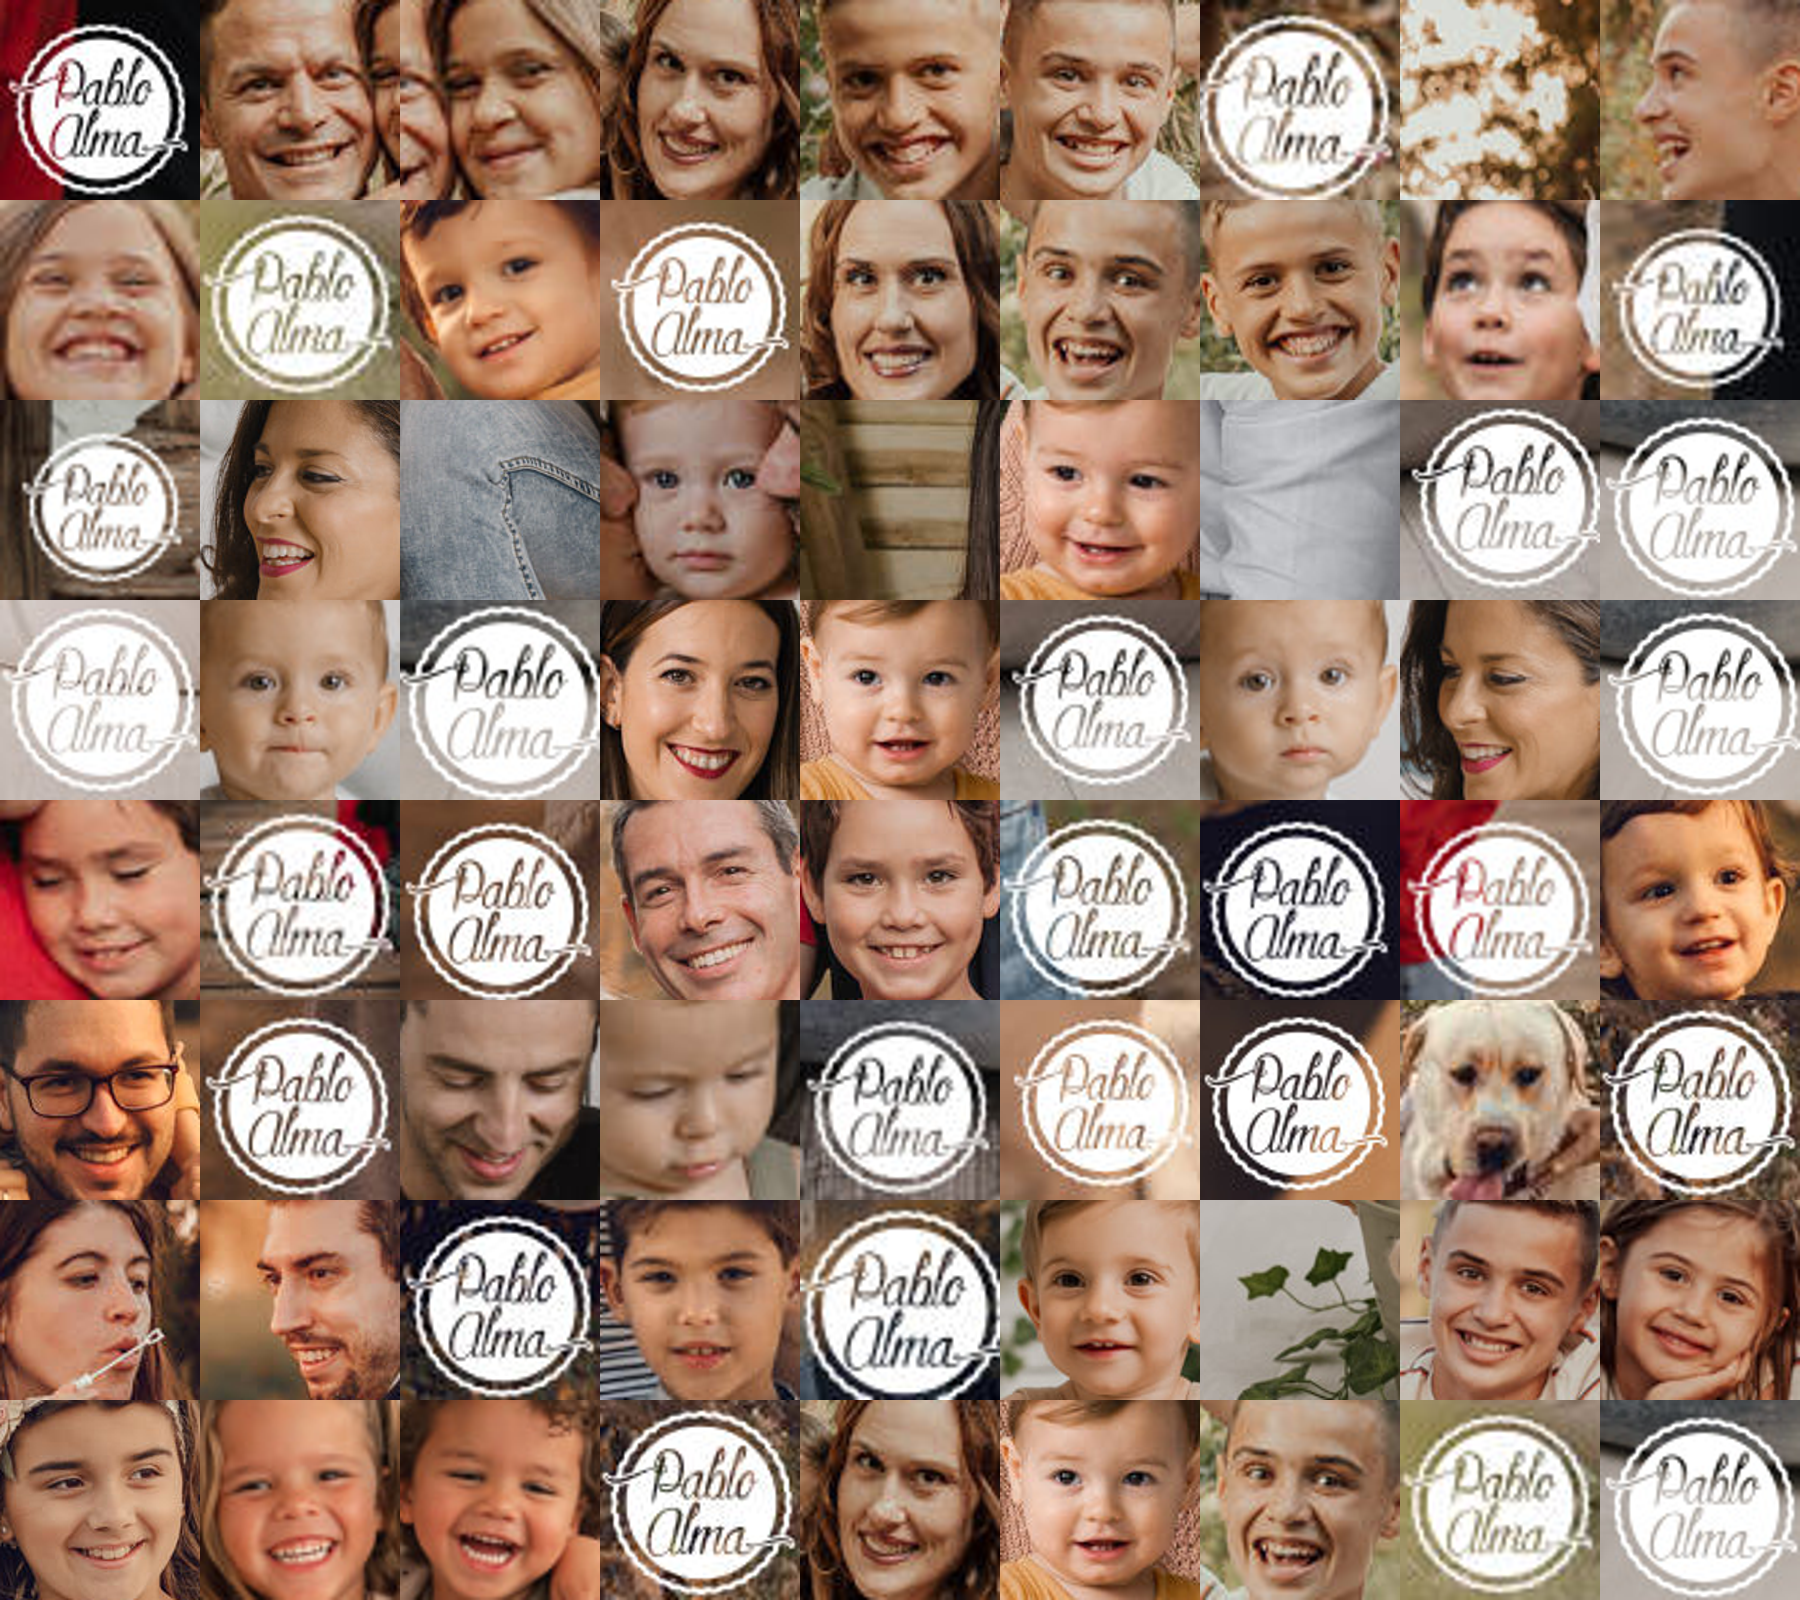

In [ ]:
create_collage(faces_list)